# Train a Regression ConvNN Model Using BOHB Tuned Hyperparameters

In this tutorial, we will be going over how to set-up, train and interpret a TelescopeML model using the built-in functions and also go over some of the important techniques and methods being applied behind the scenes in terms of: setup, pre-processing and training/predicting

For the demonstration, are going to be importing the DeepRegTrainer, DeepRegBuilder files from the **TelescopeML folder** responsible for the class that houses the model architecture and its supporting functions as well as the StatVisAnalyzer's regression_report function to get an in-depth visualization about how the model performed for the 4 distinct outputs within the given data  

In [29]:
import sys  
sys.path.insert(0, '..\\telescopeML\\telescopeML')
print(sys.path)

from DeepRegTrainer import *
from DeepRegBuilder import *
from StatVisAnalyzer import regression_report, engineered_feature_visualizer

['..\\telescopeML\\telescopeML', '..\\telescopeML\\telescopeML', '..\\telescopeML\\telescopeML', 'g:\\NASA Internship Stuff\\repos\\telescopeML_project\\notebooks', 'g:\\anaconda3\\envs\\NASA\\python311.zip', 'g:\\anaconda3\\envs\\NASA\\DLLs', 'g:\\anaconda3\\envs\\NASA\\Lib', 'g:\\anaconda3\\envs\\NASA', '', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\pysynphot-2.0.0-py3.11-win-amd64.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\photutils-1.8.0-py3.11-win-amd64.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\holoviews-1.17.0-py3.11.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\bokeh-3.0.3-py3.11.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\fonttools-4.42.0-py3.11.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\colorcet-3.0.1-py3.11.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\panel-1.2.2a1-py3.11.egg', 'g:\\anaconda3\\envs\\NASA\\Lib\\site-packages\\pyviz_comms-2.3.2-py3.11.egg', 'g:\\an

# Step 1: Load the training dataset (syntheric spectra)

The first step is going to be loading the dataset. In the example below, we have data collected on around 30,888 unique brown-dwarf spectra that spans from 0.897 micron to 2.512 micron with 104 features (instances) recorded in between. The goal of our model is to be able to predict 4 extra features accompanying the provided data that is:-
* Gravity
* Temperature 
* C/O Ratio 
* Metallicity 

of a given instance/example.

In [30]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../datasets/browndwarf_R100_v4_newWL_v2.csv.zip', compression='zip')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [31]:
print(train_BD.shape)

(30888, 109)


### 1.1: Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [32]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In the following blocks below, we are eliminating the augmented rows (atrifically created data instances) as well as loading in the flux values (X_labels) as integers seperately

In [33]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [34]:
training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [35]:
wl = pd.read_csv('../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


### 1.2: Prepare feature variables (X) and targets (y)

The next step is splitting the data into X and y sets. The X (variable) subset consists of all the features that contain the spectral flux values which is used to train the model on finding a pattern/similarities between these independent features. The y (target) subset contains the 4 distinct features (gravity, temperature, C/O ratio and metallicity) that the model is trying to predict based on the particular set of X values for a given observation.

In [36]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


We are also scaling the temperature on a $\log_{10}$ scale to reduce the magnitude of the variable while still keeping the similar variance amongst them 

In [37]:
# Eliminates the Setting With Copy Warning
y_copy = y.copy()
y_copy['temperature'] = np.log10(y_copy['temperature'])
y = y_copy

In [38]:
y.head(5)

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

In the following steps, we are going to initialize the model from the BuildCNN class. Some of the uncommon parameters required here are:
* Feature names/values: This corresponds to the flux names (string converted numerical values) and their int counterparts.
* is_tuned: **(Will probably be edited out)**
* param_grid: This is a dictionary that is used for identifying the hyperparameters to be tuned when dealing with a pre-trained model
* spectral_resolution: This value indicates the resolution of the synthetic spectra used to generate the dataset
* is_feature_improved: **(Will probably be edited out)**



# Step 2: Build the CNN model / Data processing

In [39]:
# Instintiate TrainCNNRegression class
build_cnn_regression = BuildCNN(feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

#### 2.1: Split the dataset into train, validate and test sets

After initializing our ML model, we split the processed dataset into 3 separate parts: Train, Validation and Test. 

* The training set is used to provide the model with data to analyze and understand the relationship/s between the required output and provided input information. This makes up the majority of the dataset.

* the test set is used to evaluate the model. This means that we aren't allowed to touch this data until we finish completely training the model. This is to ensure that the model is not biased towards just the data collected and is still able to accurately provide an output when given a new instance.

* Since we can encounter a bias while training the model repeatedly with the training data, we further split the training data into a validation set. This is used to evaluate the model during training and to fine tune the hyperparameters of the model. This is done to ensure that the model is not overfitting the training data and is still able to provide an accurate output when given a new instance.

In [40]:
build_cnn_regression.split_train_validation_test(test_size=0.1, 
                                                 val_size=0.1, 
                                                 random_state_=100,)

### 2.2: Scale X features - Row-wise

Another crucial step in Data Preprocessing involves standardizing the data. To address this concern, we will perform scaling on the data at the level of individual rows (per-example), ensuring that each row has a mean of 0 and a standard deviation of 1. This choice of row-wise scaling is driven by the nature of the data, which consists of a collection of time-series observations where the order of features holds significant importance. Therefore, opting for row-wise scaling is essential to maintain the inherent relationships between the features, as scaling on a per-feature basis (column-wise) could disrupt the direct associations between features. This is because the resulting scaled value would correspond to the mean and standard deviation of the feature column, potentially affecting the contextual relationships between neighboring features.

Our scaling is done using the StandardScaler() method from sklearn.preprocessing. X is transposed before applying StandardScaler() method.

The formula used to normalize the data is $$z :=\frac{x - \mu}{\sigma}$$

In [41]:
# Scale the X features using MinMax Scaler
build_cnn_regression.standardize_X_row_wise()

The boxplot below shows us a visual reference of the data (feature) ranges after scaling them using the StandardScaler(). We can interpret the boxplot as follows:

- The orange lines mark that Median which marks the middle of the quartile ranges within the data
- The box itself marks the interquartile range (IQR) which is the range between the upper and lower quartiles. This is calculated by the formula: $IQR := Q3 - Q1$
- The line above the box marks the upper quartile range where 75% of the scores fall
- The line below the box marks the lower quartile range where 25% of the scores fall

The picture below gives us an example of a visually zoomed-in description for each of the scaled feature followed by the collective box-plot

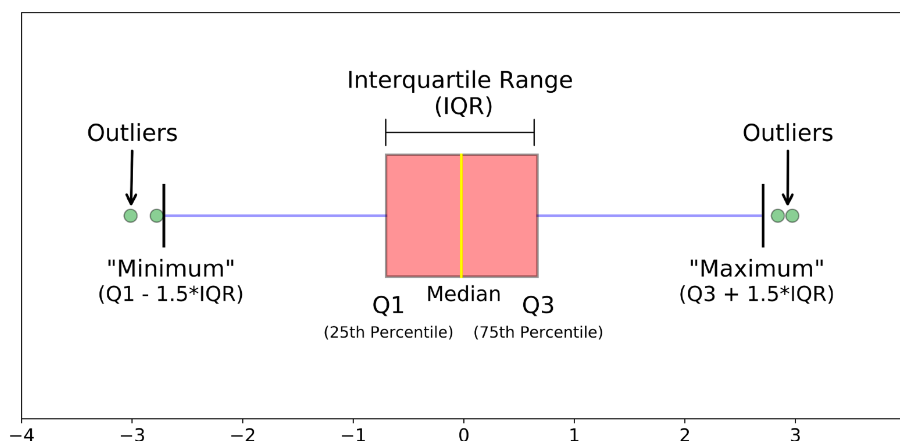

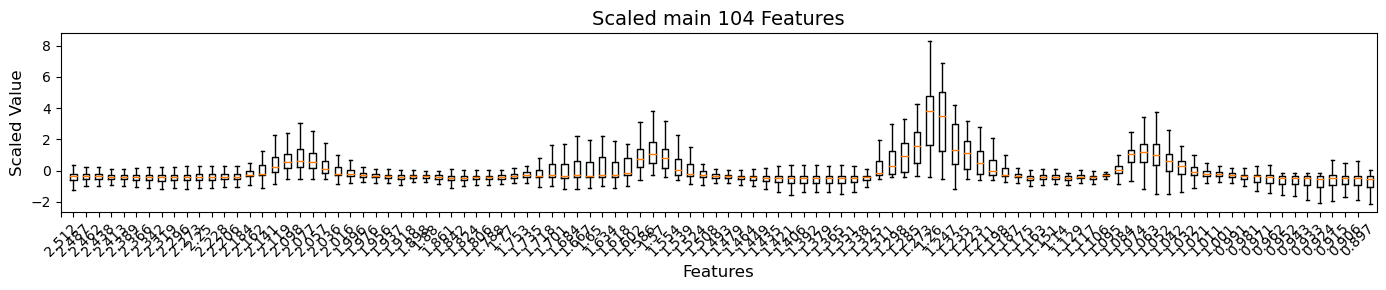

In [42]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### 2.3: Scale y features - Column-wise

Based on the similar challenge of normalization, we are going to be scaling our y features. Here, we follow the standard approach of scaling each feature column-wise as each of the output (features) are independent of each-other. If not scaled, thier magnitudes would incentivize the model to favor one output over the other based on their face values

In [43]:
# Standardize the y features using Standard Scaler
build_cnn_regression.standardize_y_column_wise()

The boxplot below follows a similar interpretation to the one above:

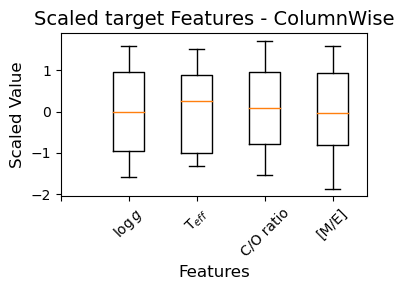

In [44]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [45]:
# build_cnn_regression.y_train_standardized_columnwise

### 2.3: Feature engeenering: Take Min and Max of each row (BD spectra) 

In our CNN model, right before the concatenated layer, we introduce a new feature engineered layer which is Min-Max. This is done to retain the range/magnitude of the flux which helps in capturing crucial information about the time series' variability or amplitude. This is also great for enhancing CNNs temporal learning capabilities which would help in forming patterns in critical points to obtain better generalizations. 

We calculate our generated feature by taking the minimum and maximum values of each example within the Train, Validation and Test sets. This is combined into a resulting array of shape (num_examples, 2) which is then concatenated with the output of the CNN model. This is then fed into the next dense layer which outputs the predicted parameters.

For example, let's see the first example from our training set X (Before standardization):

In [46]:
X.head(1)

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,8.548790e-08,6.015843e-08,9.539690e-08,7.383212e-08,...,1.257751e-07,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08


To obtain our engineered feature, we take the Min and Max fluxes within the given example. This could be visually represented as:

In [47]:
# Flux Values
tempY = np.array(X[:].loc[0])

# Wavelength Labels
tempX = (np.array(wl).T)[0]

engineered_feature_visualizer(tempX, tempY)


In [51]:
# train
build_cnn_regression.X_train_min = build_cnn_regression.X_train.min(axis=1)
build_cnn_regression.X_train_max = build_cnn_regression.X_train.max(axis=1)

# validation
build_cnn_regression.X_val_min = build_cnn_regression.X_val.min(axis=1)
build_cnn_regression.X_val_max = build_cnn_regression.X_val.max(axis=1)

# test
build_cnn_regression.X_test_min = build_cnn_regression.X_test.min(axis=1)
build_cnn_regression.X_test_max = build_cnn_regression.X_test.max(axis=1)

In [52]:
df_MinMax_train = pd.DataFrame((build_cnn_regression.X_train_min, build_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((build_cnn_regression.X_val_min, build_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((build_cnn_regression.X_test_min, build_cnn_regression.X_test_max)).T

In [53]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [54]:
df_MinMax_train.head()

,min,max
0,2.984493e-18,4.560593e-11
1,6.833671e-15,2.317328e-09
2,2.870361e-14,5.564836e-09
3,5.696652e-19,5.071436e-11
4,1.321553e-10,1.636513e-07


---

### 2.4: Scale Min Max features - ColumnWise

Similar to Standardizing the data for X and y, we ensure that the magnitude does not create a bias while learning from the data provided. Hence, these valuse are scaled column-wise as min and max are independent of each other. We also do this using the StandardScaler() similar to previous applications  

In [55]:
build_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

The box-plot below, depicts a visualization of the range of scaled features for the min and max feature values 

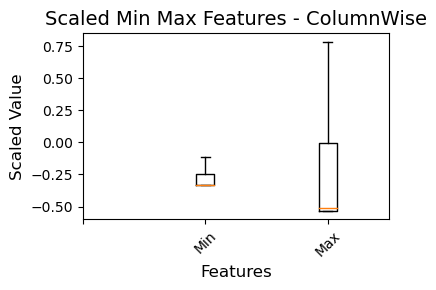

In [56]:
build_cnn_regression.plot_boxplot_scaled_features(scaled_feature= build_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Train CNN model

The next important step after the pre-processing is training the newly instantiated model. The technique we are using is a Convolutional Neural Network (CNN) which is able to predict the outputs based on dependencies/patterns established from the input data. There are many different ways of constructing a CNN but here, we are going to be focusing on the current architecture used in this example.

Our CNN can be divided into a few important layers:

* The Convolutional Layer (Conv): The main purpose of this layer is to extract low-level concentrated information into a higher-level convoluded subset through a kernel/filter. The elemination of details reveals similarity trends amongst the spectral fluxes between a group of instances. 

* The Fully Connected Layer(FC/Dense Layer): This layer receives all the data from the previous layers to every single one of its nodes. This way, we are able to cummulate all the feature information accquired from previous higher-level layers to find correlation amongst similar trends within all the data instances (i.e. the general pattern).

* The Max-Pooling Layer(Max-Pool): Similarly following the Convolutional Layer, it utilizes the kernel to aggregate lower-level data by changing the convolution function to pool the max values for each pass from the filter. This helps concentrate on the larger changes compared to all the differences collected by the Conv Layer

* Dropout Layer: This is an addition to the Fully Connected Layer where it randomly drops a certain percentage of the inputs coming into the FC layer which curbs the problem of memorizing the data (overfitting).

* Flatten Layer: This layer follows a Conv Block (Multiple Conv layers followed by a Max-Pool) which transforms the multi-dimensional information into one big flat layer that the Dense layer can extract everything from.


In [57]:
train_cnn_model = TrainCNN(
            # input dataset: StandardScaled instances  
            X1_train = build_cnn_regression.X_train_standardized_rowwise,
            X1_val   = build_cnn_regression.X_val_standardized_rowwise,
            X1_test  = build_cnn_regression.X_test_standardized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = build_cnn_regression.X_train_standardized_columnwise,
            X2_val   = build_cnn_regression.X_val_standardized_columnwise,
            X2_test  = build_cnn_regression.X_test_standardized_columnwise,

            # 1st target
            y1_train = build_cnn_regression.y_train_standardized_columnwise[:,0],
            y1_val   = build_cnn_regression.y_val_standardized_columnwise[:,0],
            y1_test  = build_cnn_regression.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = build_cnn_regression.y_train_standardized_columnwise[:,1],
            y2_val   = build_cnn_regression.y_val_standardized_columnwise[:,1],
            y2_test  = build_cnn_regression.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = build_cnn_regression.y_train_standardized_columnwise[:,2],
            y3_val   = build_cnn_regression.y_val_standardized_columnwise[:,2],
            y3_test  = build_cnn_regression.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = build_cnn_regression.y_train_standardized_columnwise[:,3],
            y4_val   = build_cnn_regression.y_val_standardized_columnwise[:,3],
            y4_test  = build_cnn_regression.y_test_standardized_columnwise[:,3],
            )

The dictionary below is used to pass into the model which specifies the architecture of the model being used to train the given data. As mentioned in the layer description above, we are using the Conv, FC, Max-pool and Flatten layers in this CNN. We also specify details like the kernel size and the number of units in each layer using the hyperparamenters dictionary. The format is described below:

- We start-off with the input layer with each instance being (104,) dimensions
- This is followed by a Conv-Block that has 3 Conv-layers of shapes (104,16), (104,64), (104,144) including a Max-Pool and Flatten Layer
- That connects onto 4 other Dense Layers of shapes (None,512), (None,2048), (None,4608), (None,8192)
- This is passed onto a Dropout FC layer of the last shape which is concatenated with the engineered features in the following Concatenated Layer that is os shape (None,8194)
-   Passing this through 2 more Dense Layers that are (None,256), (None,1024) and another Dropout FC Layer(None,1024), we then reach the simultaneous 4 output layers
- Each output layer is an FC layer of shape (None,1) that predicts one of the 4 different outputs

The learning rate component below incdicates how much the weights vary with respect to the data through each ephoch (cycle).

Note: The 'None' in shapes (None, Num-Units) indicate the batch-size which varies dynamically depending on the network's flexibility.

In [58]:
hyperparameters = {
     'Conv__MaxPooling1D': 2,
     'Conv__num_blocks': 1,
     'Conv__num_layers_per_block': 3,
     'Conv__num_filters': 4,
     'Conv__kernel_size': 6,
     'FC__NumberLayers': 4,
    
     'FC1__num_blocks' : 1,
     'FC1_num_layers_per_block': 4,
     'FC1__dropout': 0.09889223768186726,
     'FC1__units': 128,

     'FC2__num_blocks' : 1,
     'FC2_num_layers_per_block':2,
     'FC2__dropout': 0.0024609140719442646,
     'FC2__units': 64,

    
     'learning_rate': 4.9946842008422193e-05}

This provides us with a summary of the layers within our configured CNN

In [59]:
train_cnn_model.build_model(hyperparameters = hyperparameters, 
                     )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 104, 1)]             0         []                            
                                                                                                  
 Conv__B1_L1 (Conv1D)        (None, 104, 16)              112       ['input_1[0][0]']             
                                                                                                  
 Conv__B1_L2 (Conv1D)        (None, 104, 64)              6208      ['Conv__B1_L1[0][0]']         
                                                                                                  
 Conv__B1_L3 (Conv1D)        (None, 104, 144)             55440     ['Conv__B1_L2[0][0]']         
                                                                                              

The .fit_cnn_model() invokes the training procedure of the model. The budget represents the number of epochs specified by us for this session.

In [60]:
history, model =  train_cnn_model.fit_cnn_model(budget=30)

Epoch 1/30
166/782 [=====>........................] - ETA: 8:29 - loss: 0.5891 - gravity_loss: 0.2590 - c_o_ratio_loss: 0.1463 - metallicity_loss: 0.1593 - temperature_loss: 0.0244 - gravity_mae: 0.5979 - c_o_ratio_mae: 0.4156 - metallicity_mae: 0.4518 - temperature_mae: 0.1495

KeyboardInterrupt: 

### 3.1: Post Training of the CNN model

We assign the trained-model and history parameters from previously initialized class to be the newly trained model and it's history

In [ ]:
build_cnn_regression.trained_model = model
build_cnn_regression.history = history

In [ ]:
model

The history parameter of the trained model gives us the loss obtained from the last training session

In [ ]:
history.history

{'loss': [0.24889275431632996,
  0.09456111490726471,
  0.08177129179239273,
  0.06999515742063522,
  0.06781864166259766,
  0.06337405741214752,
  0.06348056346178055,
  0.05925759673118591,
  0.0583229586482048,
  0.05900980904698372,
  0.0560411773622036,
  0.054662689566612244,
  0.053180597722530365,
  0.05108613148331642,
  0.05260302498936653,
  0.049626193940639496,
  0.05006365478038788,
  0.05028960853815079,
  0.04770585149526596,
  0.049768440425395966,
  0.0457448773086071,
  0.04735540971159935,
  0.047876641154289246,
  0.04551837965846062,
  0.04683616757392883,
  0.045146066695451736,
  0.045674897730350494,
  0.045240338891744614,
  0.04518537223339081,
  0.04376613721251488],
 'gravity_loss': [0.09643923491239548,
  0.023079993203282356,
  0.01778770610690117,
  0.012498568743467331,
  0.011851692572236061,
  0.009593137539923191,
  0.009649047628045082,
  0.008105899207293987,
  0.007495857309550047,
  0.007979941554367542,
  0.006845410913228989,
  0.00624916842207

The plot_model() function provides us with a graphical representation of the model that we described in the previous steps. This also helps us better understand the flow of the layers between each other while also specifying their individual details.

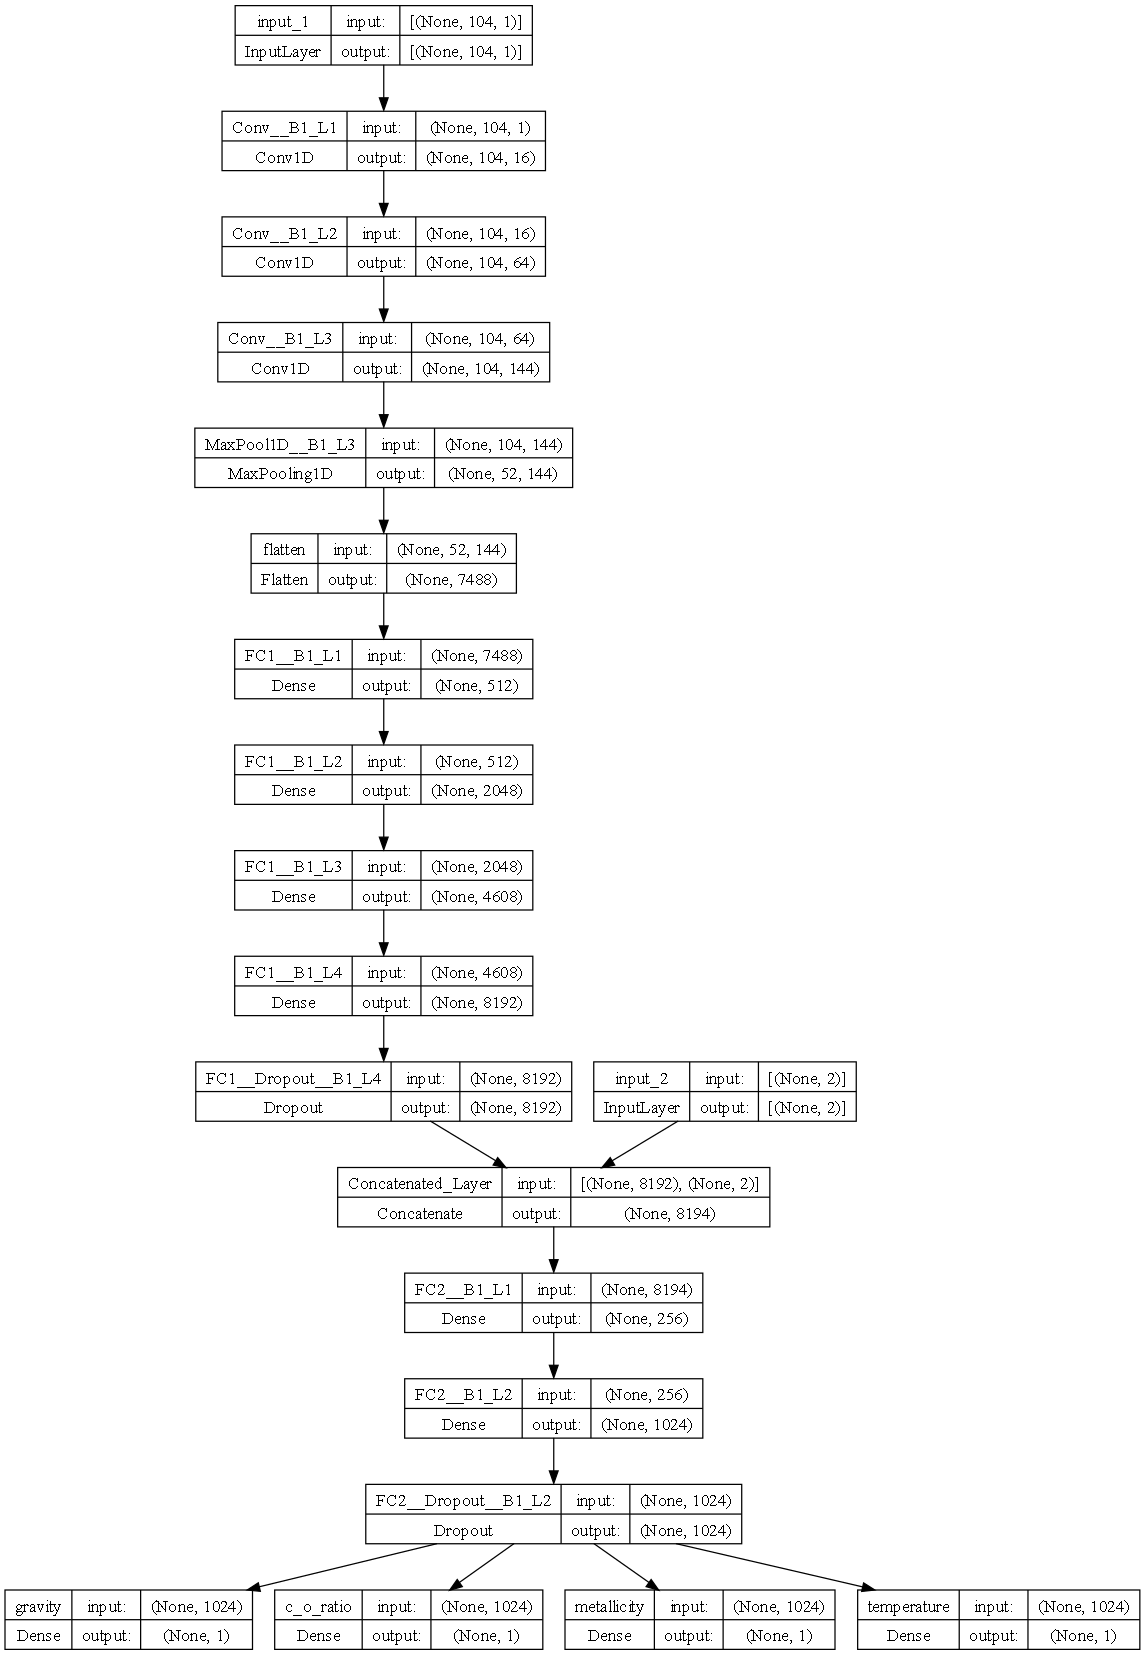

In [ ]:
tf.keras.utils.plot_model(
                train_cnn_model.model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

## Save Trained Model

In [ ]:
build_cnn_regression.trained_model.save('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__newbuild_random100_v2.h5')
build_cnn_regression.trained_model.save_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_random100_v2.h5')

with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_random100_v2.pkl', 'wb') as file:
    pk.dump(build_cnn_regression.history.history, file)
    


g:\anaconda3\envs\NASA\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load Saved Models

In [ ]:
model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters__newbuild_random100_v2.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters__newbuild_random100_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters__newbuild_random100_v2.pkl', 'rb') as file:
    history = pk.load(file)    

In [ ]:
build_cnn_regression.trained_model = model
build_cnn_regression.trained_model_history = history

# Step 4: Check Trained Model

---

In the following Step, we are able to load the previously trained model and check the summary, architecture and history from the BuildCNN object it was stored into

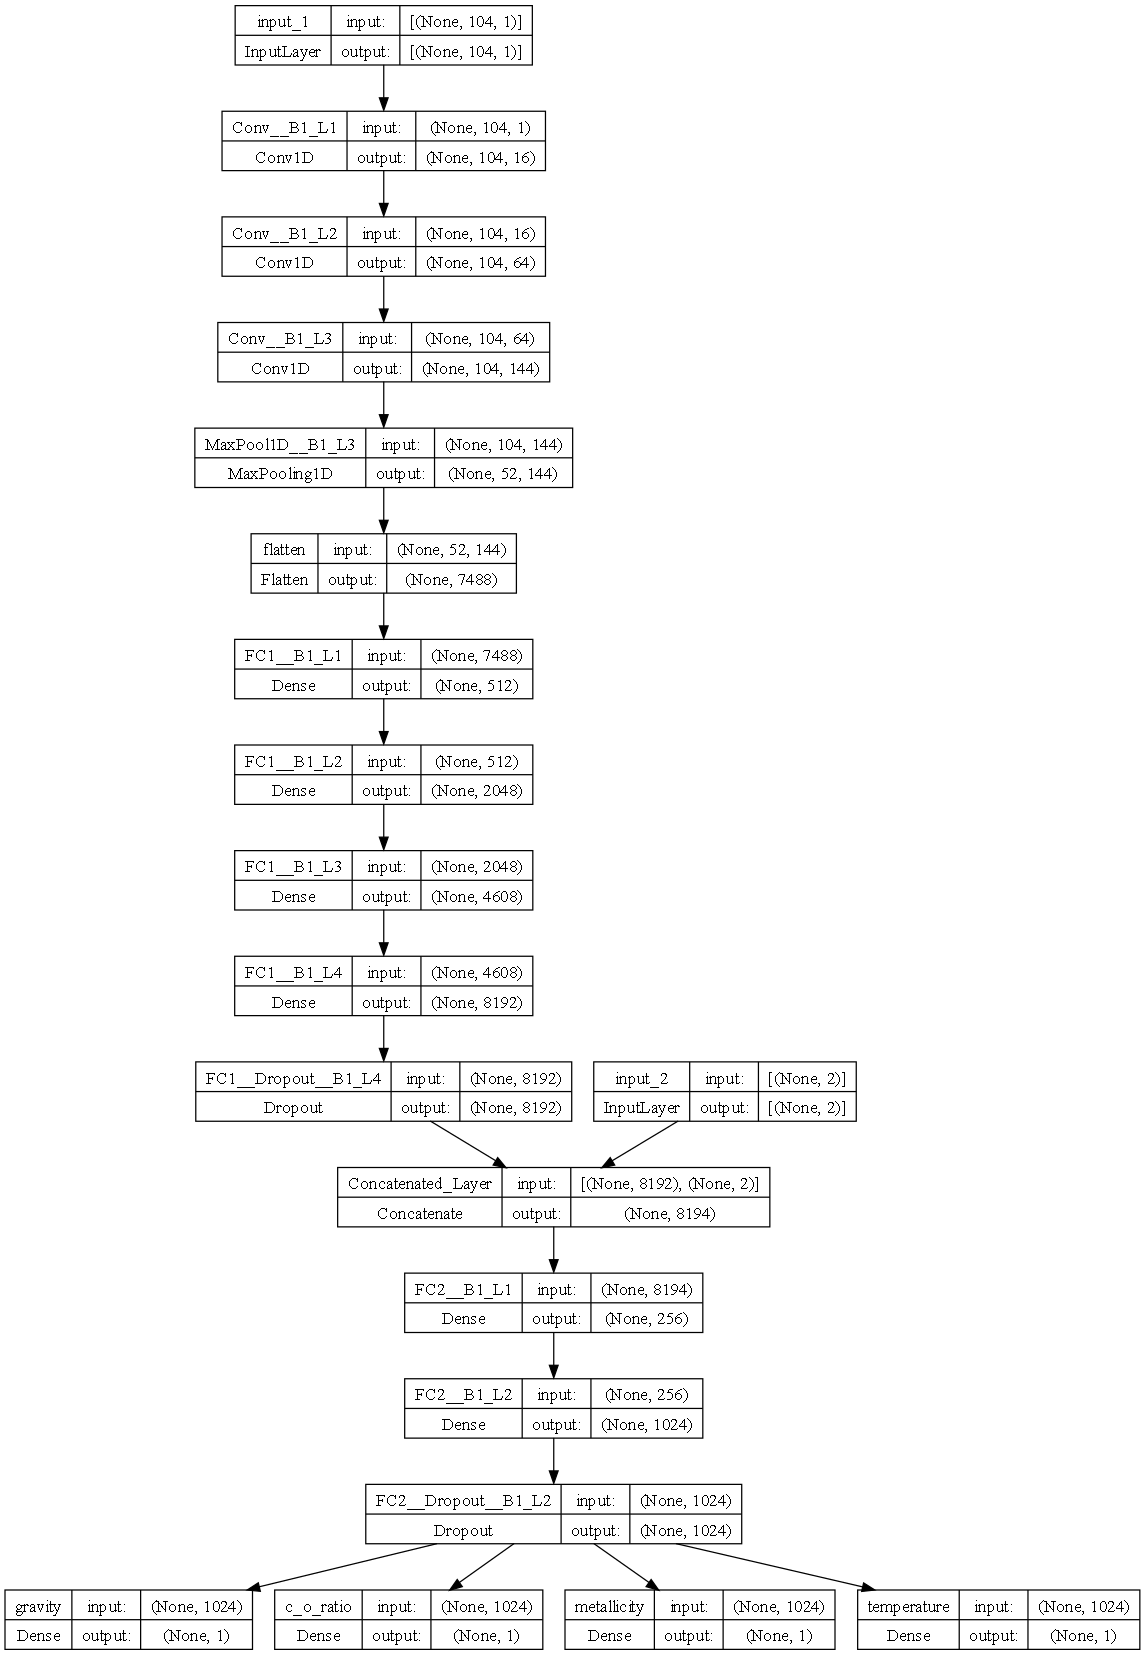

In [ ]:
tf.keras.utils.plot_model(
                build_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

In [ ]:
build_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 104, 1)]             0         []                            
                                                                                                  
 Conv__B1_L1 (Conv1D)        (None, 104, 16)              112       ['input_1[0][0]']             
                                                                                                  
 Conv__B1_L2 (Conv1D)        (None, 104, 64)              6208      ['Conv__B1_L1[0][0]']         
                                                                                                  
 Conv__B1_L3 (Conv1D)        (None, 104, 144)             55440     ['Conv__B1_L2[0][0]']         
                                                                                              

The following graph below shows us the graphical performance of the model throughout each epoch. There are two distinct lines presented within this plot. The solid line represents the loss at each point in the Epoch for the training dataset where as the dotted line gives us the loss at each point in the Epoch for our Validation Dataset. The various colors depict:

- Red: The average loss across all outputs i.e. Total Loss
- Orange: The loss calculated for the output gravity
- Green: The loss calculated for the output C_O_ratio
- Purple: The loss calculated for the output metallicity
- Brown: The loss calculated for the output temperature

One key observation from this graph is that we have the least loss encountered for Temperature where as metallicity has the highest loss calculated individually. The total loss from all the training data still falls well below $10^{-1}$

In [ ]:
build_cnn_regression.plot_model_loss(title = 'RandState=100: X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### 4.1: Plot Y predicted vs Y_Actual: Histogram & Scatter plot

In the code below, we are visualizing the model's performance for each of y's outputs. Since we have 4 different outputs where each one represents a different parameter, we will have 4 different sets of plots. 

The first plot shows us the Histogram plot of the predicted and the actual outcome overlayed on top of each other for each of the 4 values. This signifies where the probability of the prediction's magnitude of difference fromt the ground truth. If we consider our model to have good performance, we should expect to see a Gaussian Distribution of the labels. We could break down the Histogram attributes into:

- $\mu_{3\text{ train}}, \mu_{3\text{ test}}$ - Skewness of the data which helps determine whether the data has a normal or a skewed distribution
- X-Axis labels: which represent difference between the predicted and actual values i.e. residual values
- Y-Axis labels: are the logarithimic scaled values of the probability distribution for each residual instance

The second plot shows us a scatter plot between the predicted vs actual values for each of the 4 parameters. If we consider our model to have good performance, expect a continuous line line with a slope of 1. Any variation from the center(i.e. Ground Truth) is the error produced by the prediction of the model. Some of the plot's attributes are:
- $R^{2}_{train} \text{ and } R^{2}_{test}$ = $R^2$ value (representing the goodness of the fit) [$mean$ $\pm$ $Standard $ $Deviation$ of the data]
- The X and Y axis labels represending the Scaled feature values for each of the output features


97/97 [==============================] - 4s 37ms/step


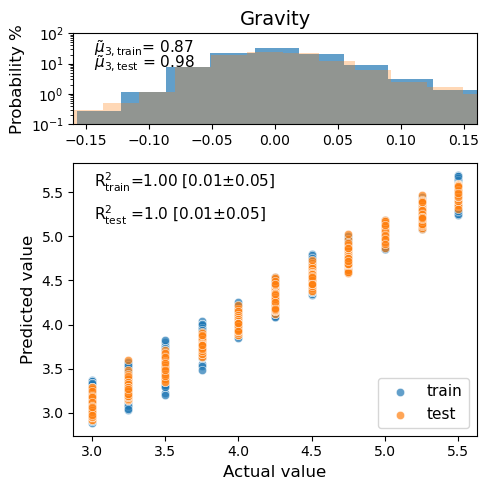

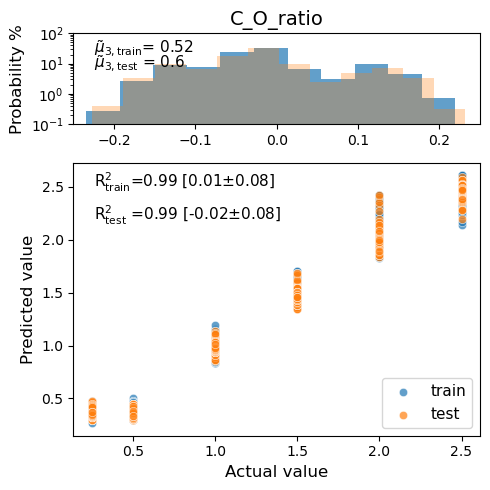

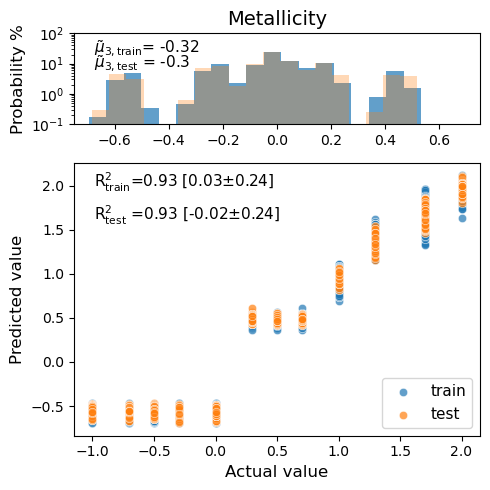

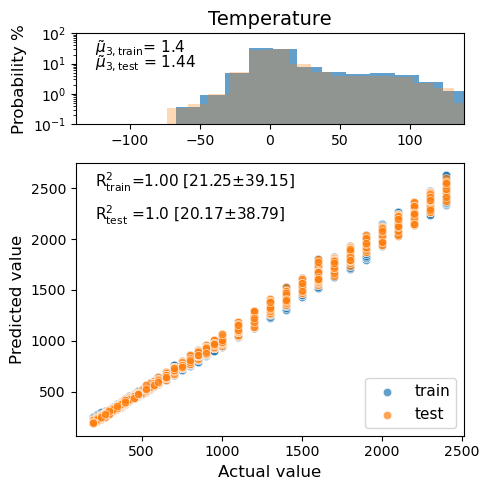

In [ ]:
i = 1
regression_report(
        trained_model = build_cnn_regression,
    
        Xtrain = [build_cnn_regression.X_train_standardized_rowwise[::i],
                  build_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [build_cnn_regression.X_test_standardized_rowwise[::i], 
                  build_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = build_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = build_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )